Imports!

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

Loading Data!

In [3]:
resultsdf = pd.read_csv("results.csv")
rankingsdf = pd.read_csv("rankings.csv")

resultsdf.head()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


In [4]:
rankingsdf.head()

,date,Scotland,England,Ireland,Wales,Australia,New Zealand,France,South Africa,Argentina,Italy
0,1871-03-27,81.000,79.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1872-02-05,79.800,80.2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1873-03-03,79.840,80.1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1874-02-23,78.872,81.1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1875-02-15,78.872,82.0152,79.1128,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#PROBLEM ABOVE! SCORES ARE NOT UPDATED TO MODERN ERA UNTIL 1992!
resultsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         2783 non-null   object
 1   home_team    2783 non-null   object
 2   away_team    2783 non-null   object
 3   home_score   2783 non-null   int64 
 4   away_score   2783 non-null   int64 
 5   competition  2760 non-null   object
 6   stadium      2783 non-null   object
 7   city         2783 non-null   object
 8   country      2783 non-null   object
 9   neutral      2783 non-null   bool  
 10  world_cup    2783 non-null   bool  
dtypes: bool(2), int64(2), object(7)
memory usage: 201.2+ KB


Cleaning Data and Filtering to 1992!

In [6]:
#Fix dates
resultsdf['date'] = pd.to_datetime(resultsdf['date'])

#define winner
def winner(row):
    if row['home_score'] > row['away_score']:
        return 'home_win'
    elif row['home_score'] < row['away_score']:
        return 'away_win'
    else:
        return 'draw'

#apply the func
resultsdf['winner'] = resultsdf.apply(winner, axis=1)

#pd
resultsdf['point_difference'] = (resultsdf['home_score'] - resultsdf['away_score']).abs()


In [7]:
#Cutoff for new df with correct scoring
modern_era = '1992-01-01'

resultsdf_modern = resultsdf[(resultsdf['date'] >= modern_era) & (resultsdf['winner'] != 'draw')].copy()

resultsdf_modern.head()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup,winner,point_difference
1309,1992-01-18,Ireland,Wales,15,16,1992 Five Nations Championship,Lansdowne Road,Dublin,Ireland,False,False,away_win,1
1310,1992-01-18,Scotland,England,7,25,1992 Five Nations Championship,Murrayfield Stadium,Edinburgh,Scotland,False,False,away_win,18
1311,1992-02-01,Wales,France,9,12,1992 Five Nations Championship,National Stadium,Cardiff,Wales,False,False,away_win,3
1312,1992-02-01,England,Ireland,38,9,1992 Five Nations Championship,Twickenham,London,England,False,False,home_win,29
1313,1992-02-15,France,England,13,31,1992 Five Nations Championship,Parc des Princes,Paris,France,False,False,away_win,18


In [8]:
resultsdf_modern.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1443 entries, 1309 to 2782
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1443 non-null   datetime64[ns]
 1   home_team         1443 non-null   object        
 2   away_team         1443 non-null   object        
 3   home_score        1443 non-null   int64         
 4   away_score        1443 non-null   int64         
 5   competition       1427 non-null   object        
 6   stadium           1443 non-null   object        
 7   city              1443 non-null   object        
 8   country           1443 non-null   object        
 9   neutral           1443 non-null   bool          
 10  world_cup         1443 non-null   bool          
 11  winner            1443 non-null   object        
 12  point_difference  1443 non-null   int64         
dtypes: bool(2), datetime64[ns](1), int64(3), object(7)
memory usage: 138.1+ KB


Feature Engineering!

In [9]:
#fix competition nulls
resultsdf_modern['competition'] = resultsdf_modern['competition'].fillna('Friendly')

#win % (has to be chronological) HISTORICAL (not too good but gives idea of the team)
resultsdf_modern.sort_values(by='date', inplace=True)

#store historic perc stats
team_hperc_stats = {} 

resultsdf_modern['home_team_win_perc'] = 0.0
resultsdf_modern['away_team_win_perc'] = 0.0

#for each row, calculate the home win % and away win %
for index, row in resultsdf_modern.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    winner = row['winner']
    
    if home_team not in team_hperc_stats:
        team_hperc_stats[home_team] = {'matches_played': 0, 'wins': 0}
    if away_team not in team_hperc_stats:
        team_hperc_stats[away_team] = {'matches_played': 0, 'wins': 0}

    home_matches = team_hperc_stats[home_team]['matches_played']
    home_wins = team_hperc_stats[home_team]['wins']
    away_matches = team_hperc_stats[away_team]['matches_played']
    away_wins = team_hperc_stats[away_team]['wins']
    
    home_win_perc = (home_wins / home_matches) if home_matches > 0 else 0.5
    away_win_perc = (away_wins / away_matches) if away_matches > 0 else 0.5
    
    resultsdf_modern.at[index, 'home_team_win_perc'] = home_win_perc
    resultsdf_modern.at[index, 'away_team_win_perc'] = away_win_perc
    
    team_hperc_stats[home_team]['matches_played'] += 1
    team_hperc_stats[away_team]['matches_played'] += 1
    
    if winner == 'home_win':
        team_hperc_stats[home_team]['wins'] += 1
    elif winner == 'away_win':
        team_hperc_stats[away_team]['wins'] += 1

#check
resultsdf_modern.tail()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup,winner,point_difference,home_team_win_perc,away_team_win_perc
2778,2024-07-13,Argentina,France,33,25,2024 France tour of Argentina,José Amalfitani Stadium,Buenos Aires,Argentina,False,False,home_win,8,0.282511,0.559486
2779,2024-08-10,Australia,South Africa,7,33,2024 Rugby Championship,Suncorp Stadium,Brisbane,Australia,False,False,away_win,26,0.562310,0.602524
2780,2024-08-10,New Zealand,Argentina,30,38,2024 Rugby Championship,Wellington Regional Stadium,Wellington,New Zealand,False,False,away_win,8,0.805031,0.285714
2781,2024-08-17,New Zealand,Argentina,42,10,2024 Rugby Championship,Eden Park,Auckland,New Zealand,True,False,home_win,32,0.802508,0.288889
2782,2024-08-17,Australia,South Africa,12,30,2024 Rugby Championship,Optus Stadium,Perth,Australia,False,False,away_win,18,0.560606,0.603774


In [10]:
#store next features form and h2h
team_form = {}
h2h_stats = {}

#count back 10 matches
form_count = 10

#must do home and away due to data
resultsdf_modern['home_team_form_perc'] = 0.5
resultsdf_modern['away_team_form_perc'] = 0.5
resultsdf_modern['home_team_h2h_win_perc'] = 0.5
resultsdf_modern['away_team_h2h_win_perc'] = 0.5

#for each row calculate both form and h2h
for index, row in resultsdf_modern.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    winner = row['winner']
    
    if home_team not in team_form:
        team_form[home_team] = []
    if away_team not in team_form:
        team_form[away_team] = []

    h2h_key_teams = sorted([home_team, away_team])
    h2h_key = f"{h2h_key_teams[0]}_vs_{h2h_key_teams[1]}"
    
    if h2h_key not in h2h_stats:
        h2h_stats[h2h_key] = {'matches': 0, h2h_key_teams[0]: 0, h2h_key_teams[1]: 0}

    home_form_list = team_form[home_team]
    away_form_list = team_form[away_team]
    
    if len(home_form_list) > 0:
        home_form_wins = home_form_list.count('W')
        resultsdf_modern.at[index, 'home_team_form_perc'] = home_form_wins / len(home_form_list)
        
    if len(away_form_list) > 0:
        away_form_wins = away_form_list.count('W')
        resultsdf_modern.at[index, 'away_team_form_perc'] = away_form_wins / len(away_form_list)


    h2h_matches = h2h_stats[h2h_key]['matches']
    if h2h_matches > 0:
        home_team_h2h_wins = h2h_stats[h2h_key][home_team]
        resultsdf_modern.at[index, 'home_team_h2h_win_perc'] = home_team_h2h_wins / h2h_matches
        
        away_team_h2h_wins = h2h_stats[h2h_key][away_team]
        resultsdf_modern.at[index, 'away_team_h2h_win_perc'] = away_team_h2h_wins / h2h_matches

    h2h_stats[h2h_key]['matches'] += 1
    
    if winner == 'home_win':
        team_form[home_team].append('W')
        team_form[away_team].append('L')
        h2h_stats[h2h_key][home_team] += 1
    else:
        team_form[home_team].append('L')
        team_form[away_team].append('W')
        h2h_stats[h2h_key][away_team] += 1

    # only in the form count
    if len(team_form[home_team]) > form_count:
        team_form[home_team].pop(0)
    if len(team_form[away_team]) > form_count:
        team_form[away_team].pop(0)

resultsdf_modern.tail()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup,winner,point_difference,home_team_win_perc,away_team_win_perc,home_team_form_perc,away_team_form_perc,home_team_h2h_win_perc,away_team_h2h_win_perc
2778,2024-07-13,Argentina,France,33,25,2024 France tour of Argentina,José Amalfitani Stadium,Buenos Aires,Argentina,False,False,home_win,8,0.282511,0.559486,0.2,0.8,0.354839,0.645161
2779,2024-08-10,Australia,South Africa,7,33,2024 Rugby Championship,Suncorp Stadium,Brisbane,Australia,False,False,away_win,26,0.562310,0.602524,0.3,0.8,0.548387,0.451613
2780,2024-08-10,New Zealand,Argentina,30,38,2024 Rugby Championship,Wellington Regional Stadium,Wellington,New Zealand,False,False,away_win,8,0.805031,0.285714,0.7,0.3,0.933333,0.066667
2781,2024-08-17,New Zealand,Argentina,42,10,2024 Rugby Championship,Eden Park,Auckland,New Zealand,True,False,home_win,32,0.802508,0.288889,0.6,0.4,0.903226,0.096774
2782,2024-08-17,Australia,South Africa,12,30,2024 Rugby Championship,Optus Stadium,Perth,Australia,False,False,away_win,18,0.560606,0.603774,0.3,0.8,0.539683,0.460317


In [11]:
#reload for ease
rankingsdf = pd.read_csv("rankings.csv")

#Time to deal with rankings! Must clean first
rankingsdf['date'] = pd.to_datetime(rankingsdf['date'])
rankingsdf.sort_values(by='date', inplace=True)

#MELT IT so it's long and then sort
rankingsdf = pd.melt(
    rankingsdf, 
    id_vars=['date'],
    var_name='team',
    value_name='points'
)
rankingsdf.sort_values(by='date', inplace=True)

#merge resultsdf and rankingsdf home and away
df = pd.merge_asof(
    resultsdf_modern,
    rankingsdf.rename(columns={'team': 'home_team', 'points': 'home_team_ranking_points'}),
    on='date',
    by='home_team'
)

df = pd.merge_asof(
    df,
    rankingsdf.rename(columns={'team': 'away_team', 'points': 'away_team_ranking_points'}),
    on='date',
    by='away_team'
)

df.dropna(inplace=True)

#done! now lets check everything with all of our features!
feature_cols = [
    'date', 'home_team', 'away_team', 'winner',
    'home_team_ranking_points', 'away_team_ranking_points',
    'home_team_form_perc', 'away_team_form_perc',
    'home_team_h2h_win_perc', 'away_team_h2h_win_perc'
]
print(df[feature_cols].tail())

           date    home_team     away_team    winner  \
1438 2024-07-13    Argentina        France  home_win   
1439 2024-08-10    Australia  South Africa  away_win   
1440 2024-08-10  New Zealand     Argentina  away_win   
1441 2024-08-17  New Zealand     Argentina  home_win   
1442 2024-08-17    Australia  South Africa  away_win   

      home_team_ranking_points  away_team_ranking_points  home_team_form_perc  \
1438                 76.932751                 81.750478                  0.2   
1439                 75.087091                 87.158565                  0.3   
1440                 83.689823                 78.794648                  0.7   
1441                 84.455547                 78.028924                  0.6   
1442                 75.397812                 86.847844                  0.3   

      away_team_form_perc  home_team_h2h_win_perc  away_team_h2h_win_perc  
1438                  0.8                0.354839                0.645161  
1439                  0.

FE additions

In [12]:
#a few more features I thought of
last_played_date = {}

#default rustyness
df['home_team_rust_days'] = 180
df['away_team_rust_days'] = 180

# for each row calculate the teams time since last played
for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    current_date = row['date']
    
    if home_team in last_played_date:
        days_since_played = (current_date - last_played_date[home_team]).days
        df.at[index, 'home_team_rust_days'] = days_since_played
        
    if away_team in last_played_date:
        days_since_played = (current_date - last_played_date[away_team]).days
        df.at[index, 'away_team_rust_days'] = days_since_played
        
    last_played_date[home_team] = current_date
    last_played_date[away_team] = current_date
df.tail()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,...,home_team_win_perc,away_team_win_perc,home_team_form_perc,away_team_form_perc,home_team_h2h_win_perc,away_team_h2h_win_perc,home_team_ranking_points,away_team_ranking_points,home_team_rust_days,away_team_rust_days
1438,2024-07-13,Argentina,France,33,25,2024 France tour of Argentina,José Amalfitani Stadium,Buenos Aires,Argentina,False,...,0.282511,0.559486,0.2,0.8,0.354839,0.645161,76.932751,81.750478,7,7
1439,2024-08-10,Australia,South Africa,7,33,2024 Rugby Championship,Suncorp Stadium,Brisbane,Australia,False,...,0.562310,0.602524,0.3,0.8,0.548387,0.451613,75.087091,87.158565,28,28
1440,2024-08-10,New Zealand,Argentina,30,38,2024 Rugby Championship,Wellington Regional Stadium,Wellington,New Zealand,False,...,0.805031,0.285714,0.7,0.3,0.933333,0.066667,83.689823,78.794648,28,28
1441,2024-08-17,New Zealand,Argentina,42,10,2024 Rugby Championship,Eden Park,Auckland,New Zealand,True,...,0.802508,0.288889,0.6,0.4,0.903226,0.096774,84.455547,78.028924,7,7
1442,2024-08-17,Australia,South Africa,12,30,2024 Rugby Championship,Optus Stadium,Perth,Australia,False,...,0.560606,0.603774,0.3,0.8,0.539683,0.460317,75.397812,86.847844,7,7


In [13]:
#some more :)

df['rust_diff'] = df['home_team_rust_days'] - df['away_team_rust_days']
df['ranking_diff'] = df['home_team_ranking_points'] - df['away_team_ranking_points']
df['form_diff'] = df['home_team_form_perc'] - df['away_team_form_perc']
df['h2h_diff'] = df['home_team_h2h_win_perc'] - df['away_team_h2h_win_perc']

#encode target
df['winner_encoded'] = np.where(df['winner'] == 'home_win', 1, 0)

#ALMOST FORGOT this, booleans must be int type :))
df['neutral'] = df['neutral'].astype(int)
df['world_cup'] = df['world_cup'].astype(int)

features = [
    'ranking_diff',
    'form_diff',
    'h2h_diff',
    'rust_diff',
    'home_team_rust_days', 
    'away_team_rust_days',
    'home_team_win_perc',
    'away_team_win_perc',
    'neutral',            
    'world_cup'           
]

target = 'winner_encoded'

X = df[features]
y = df[target]

X.tail()

,ranking_diff,form_diff,h2h_diff,rust_diff,home_team_rust_days,away_team_rust_days,home_team_win_perc,away_team_win_perc,neutral,world_cup
1438,-4.817727,-0.6,-0.290323,0,7,7,0.282511,0.559486,0,0
1439,-12.071474,-0.5,0.096774,0,28,28,0.562310,0.602524,0,0
1440,4.895175,0.4,0.866667,0,28,28,0.805031,0.285714,0,0
1441,6.426623,0.2,0.806452,0,7,7,0.802508,0.288889,1,0
1442,-11.450032,-0.5,0.079365,0,7,7,0.560606,0.603774,0,0


Modelling time!

In [14]:
#Benchmark will be XGBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=False)

#model
model_xgb = XGBClassifier(
    n_estimators=100,
    early_stopping_rounds=10,
    eval_metric='logloss',
    random_state=0
)

#fit
model_xgb.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

all_probabilities = model_xgb.predict_proba(X_test)
home_win_probabilities = all_probabilities[:, 1] 

#predict
y_pred = model_xgb.predict(X_test)

#evaluation to compare with DL model!
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, home_win_probabilities)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Home Win']))

Accuracy: 91.35%
ROC-AUC Score: 0.9716

Classification report:
              precision    recall  f1-score   support

    Away Win       0.94      0.84      0.89       119
    Home Win       0.90      0.96      0.93       170

    accuracy                           0.91       289
   macro avg       0.92      0.90      0.91       289
weighted avg       0.92      0.91      0.91       289



Feature Importance

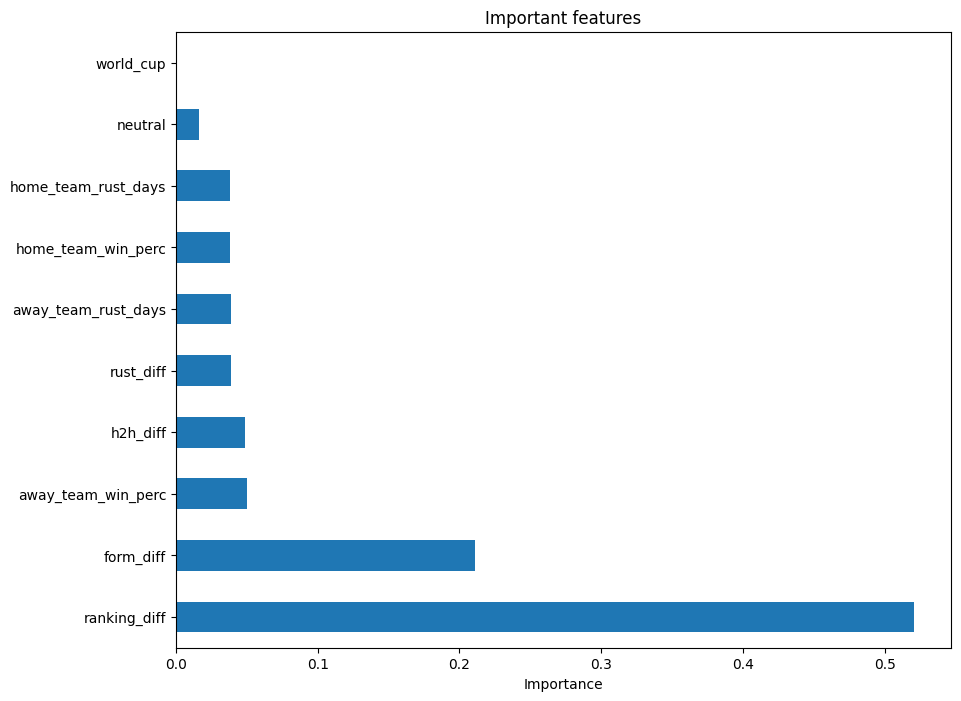

In [15]:
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(model_xgb.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Important features')
plt.xlabel('Importance')
plt.show()

In [18]:
#challenger will be a Deep learning LSTM network

#scale the data and re split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, test_size=0.2, shuffle=False)

#reshape for model (3d)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


#model
model_lstm = Sequential()
model_lstm.add(LSTM(
    units=50,
    activation='relu', 
    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
))
# prevent overfit
model_lstm.add(Dropout(0.2)) 

model_lstm.add(Dense(units=10, activation='relu'))

#output layer
model_lstm.add(Dense(units=1, activation='sigmoid')) 

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)

model_lstm.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#fit
history = model_lstm.fit(
    X_train_lstm, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stop],
    verbose=0
)


#predict
y_prob_lstm = model_lstm.predict(X_test_lstm).flatten()
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

#evaluation to compare with XGB model!
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
roc_auc_lstm = roc_auc_score(y_test, y_prob_lstm)

print(f"\nAccuracy: {accuracy_lstm * 100:.2f}%")
print(f"ROC-AUC Score: {roc_auc_lstm:.4f}")


c:\Users\marcu\Documents\VSCode\rugby-predictor\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,721 (49.69 KB)

 Trainable params: 12,721 (49.69 KB)

 Non-trainable params: 0 (0.00 B)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Accuracy: 94.12%
ROC-AUC Score: 0.9856


WOW! The LSTM model defeats XGBoost.

In [ ]:
#save model
model_lstm.save('rugby_predictor.keras')
#save scalar 
joblib.dump(scaler, 'scaler.joblib')